In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
A = lambda eps: np.array([[1, eps], [0, 2]])

eps_range = np.linspace(-1, 1, 100)

all_eigenvals = []
all_eigenvecs = []
for eps in eps_range:
    eigenvals, eigenvecs = np.linalg.eig(A(eps))
    all_eigenvals.append(eigenvals)
    all_eigenvecs.append(eigenvecs)

all_eigenvals = np.array(all_eigenvals)
all_eigenvecs = np.array(all_eigenvecs)

In [3]:
print(A(eps_range[0]) @ all_eigenvecs[0, :, 1], all_eigenvals[0, 1] * all_eigenvecs[0, :, 1])

[-1.41421356  1.41421356] [-1.41421356  1.41421356]


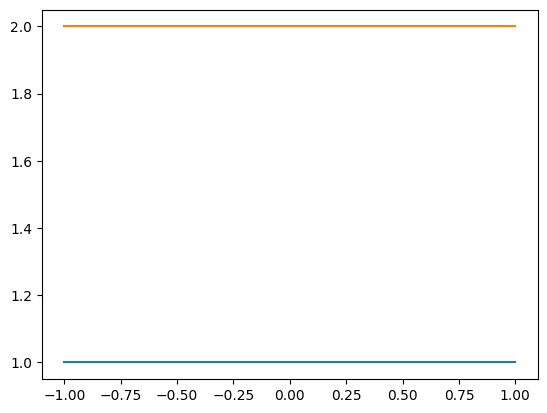

In [4]:
plt.plot(eps_range, all_eigenvals[:, 0], label='eigenvalue 1')
plt.plot(eps_range, all_eigenvals[:, 1], label='eigenvalue 2')

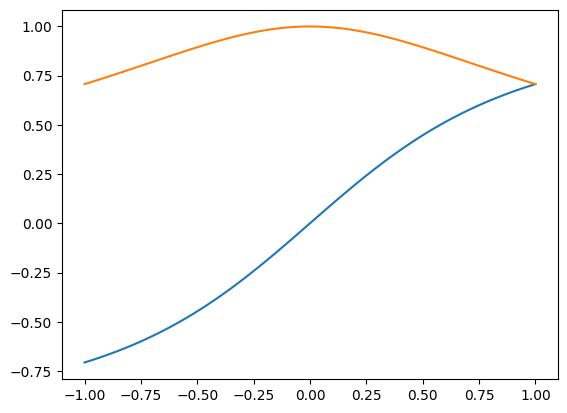

In [5]:
plt.plot(eps_range, all_eigenvecs[:, 0, 1])
plt.plot(eps_range, all_eigenvecs[:, 1, 1])

In [6]:
# Test imports

import sys
sys.path.append('../')
from models import GaussianProcess, WeightSpaceGaussianProcess
import utils
import jax
import jax.numpy as jnp

/Users/victorgeadah_maciii/anaconda3/envs/fi_gp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
D1, D2 = 3, 2
kernel_A = utils.get_kernel([{'type':'RBF','scale': 1e0,'sigma': 10.,'normalizer': 1.}], 1e-5)
A_gp1 = GaussianProcess(kernel_A, D1, D2)

In [8]:
ts = jnp.linspace(0, 5, 100)
A_gp1.sample(jax.random.PRNGKey(0), ts).shape

(3, 2, 100)

[[598.2469  598.4043 ]
 [598.2175  599.4238 ]
 [598.5508  598.89874]]


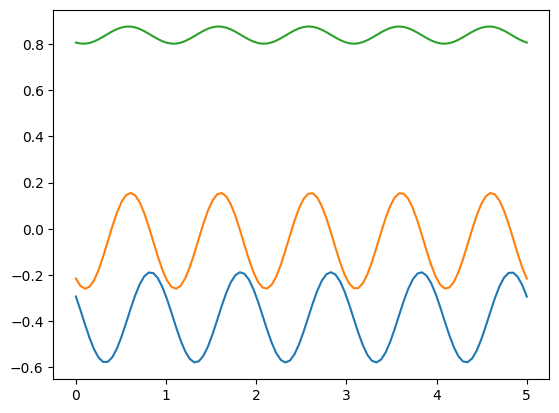

In [10]:
basis_funcs = utils.torus_basis(N=10, sigma=1.0, kappa=0.5)
A_gp2 = WeightSpaceGaussianProcess(basis_funcs, D1, D2)
A_gp2_samples = A_gp2.sample(jax.random.PRNGKey(1), ts)

# for t in range(len(ts)):
#     A_gp2_samples = A_gp2_samples.at[t, 0, 1].set(0)
print(A_gp2.log_prob(ts, A_gp2_samples))

plt.plot(ts, A_gp2_samples[:, 0, 0])
plt.plot(ts, A_gp2_samples[:, 0, 1])
plt.plot(ts, A_gp2_samples[:, 1, 1])

In [15]:
def is_symmetric(A):
    return jnp.allclose(A, A.T)

In [38]:
import jax.random as jxr
len_basis = 10
D_1 = 3
D_2 = 4
T = 8
PhiAp = jxr.normal(jax.random.PRNGKey(0), (T, len_basis))
Exp = jxr.normal(jax.random.PRNGKey(1), (T, D_1))

PhiAp_Exp1 = jnp.einsum('tk,ti->tki', PhiAp, Exp)
PhiAp_Exp2 = jnp.multiply(PhiAp[:, :, None], Exp[:, None, :])
assert jnp.allclose(PhiAp_Exp1, PhiAp_Exp2)

PhiAp_Exp1_flat = jnp.reshape(PhiAp_Exp1, (T, -1))
t1 = PhiAp_Exp1_flat.T @ PhiAp_Exp1_flat
print(t1.shape) # KD_1 x KD_1
assert is_symmetric(t1)

t1_2 = jnp.einsum('tki,tlj->kilj', PhiAp_Exp1, PhiAp_Exp1).reshape(len_basis * D1, len_basis * D1)
assert jnp.allclose(t1, t1_2)
assert is_symmetric(t1_2)

# Now with matrices

Lxp = jxr.normal(jax.random.PRNGKey(2), (T, D_1, D_1))
Vxp = jax.vmap(lambda L: L @ L.T)(Lxp)
assert is_symmetric(Vxp[0])
PhiAp_Lxp = jnp.einsum('tk,tij->tkij', PhiAp, Lxp)
t2 = jax.vmap(lambda phiL: jnp.einsum('kid,ljd->kilj', phiL, phiL))(PhiAp_Lxp).sum(0)
t2 = t2.reshape(len_basis * D1, len_basis * D1)
assert is_symmetric(t2)

t2_2 = jnp.einsum('tkid,tljd->kilj', PhiAp_Lxp, PhiAp_Lxp)
t2_2 = t2_2.reshape(len_basis * D1, len_basis * D1)
assert is_symmetric(t2_2)
assert jnp.allclose(t2, t2_2, atol=1e-5)

(30, 30)
